# Abnormalities

## Looking at rate of change..

In [56]:
%matplotlib inline
%env KERAS_BACKEND=tensorflow 

from keras.models import load_model
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.losses import mean_squared_error
from keras.losses import mean_absolute_percentage_error
from keras.callbacks import TensorBoard

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import common

env: KERAS_BACKEND=tensorflow


In [39]:
df = common.load_df("../data/insead", "*.csv")
print(common.load_df.cache_info())

cols = ["cwshdr"]
df = common.Process.replace_nulls(df, cols=cols)
df = common.Process.replace_with_near(df, cols=cols)
df = common.Process.smooth_data(df, cols=cols)
df = common.Process.get_normalized_df(df, cols=cols)

# create features
df["hour"] = df.index.hour

# take train and test data.. 
train = df["2016-01-01":"2016-01-15"]
test = df["2016-01-16":"2016-01-16"]

CacheInfo(hits=6, misses=1, maxsize=None, currsize=1)


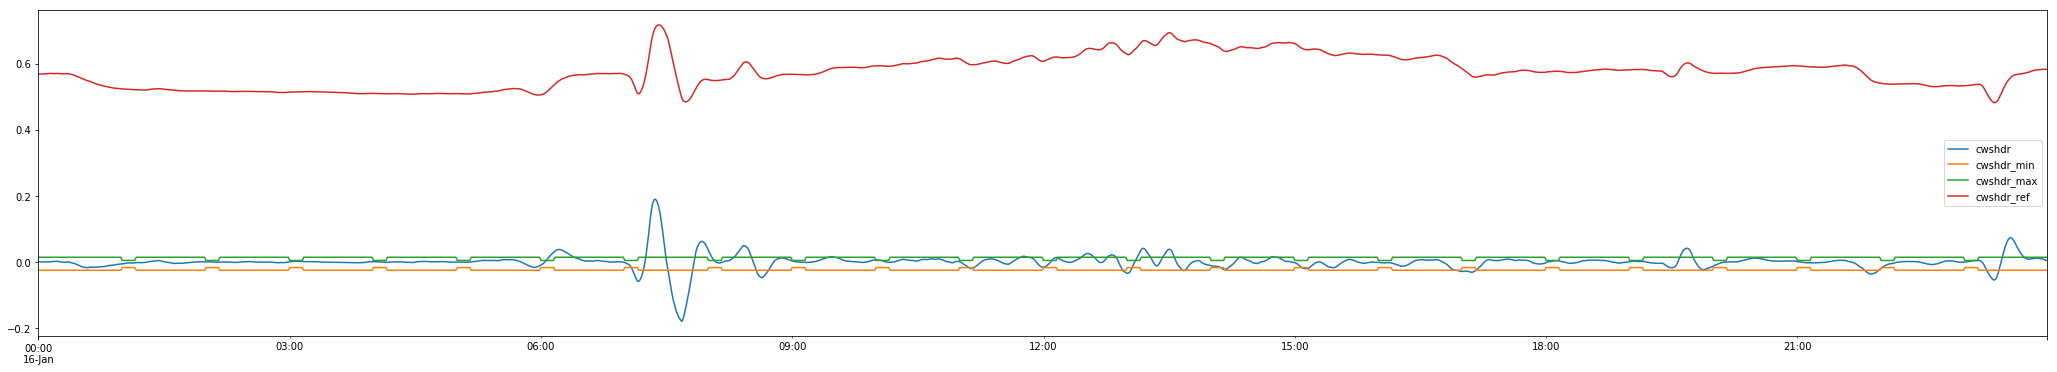

In [51]:
# rate of change.
first_order_diff = lambda x, delta: (x - x.shift(delta)).fillna(0)
train_rate = first_order_diff(train, delta=10)
test_rate = first_order_diff(test, delta=10)

# Assuming 1hr bins. group data.
min_per_hr = train_rate.groupby(["hour"]).quantile(.1)
max_per_hr = test_rate.groupby(["hour"]).quantile(.9)

# set columns with bin values.
test_rate["cwshdr_min"] = test_rate.hour.apply(lambda x: min_per_hr.cwshdr.iloc[int(x)])
test_rate["cwshdr_max"] = test_rate.hour.apply(lambda x: max_per_hr.cwshdr.iloc[int(x)])

# normalized
test_rate["cwshdr_ref"] = test["cwshdr"]

# # plot.
fig, ax = plt.subplots(1,1,figsize=(36,6))
test_rate[["cwshdr", "cwshdr_min", "cwshdr_max", "cwshdr_ref"]].plot(ax=ax)

Again, the hypothesis isn't solid... huuhhhh!!!!

## Comparing with the model